In [ ]:
# Implementing the Quantum Counting Algorithm

In [10]:
# Creating the Grover circuit (codes copied from general Grover circuit construction)

In [74]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
import numpy as np

n = 3 # no. of working/counting qubits (= no. of bits in "w")
q = 2 * n - 1 # no. of total qubits needed (including n-1 auxiliary and ancilla qubits)

In [7]:
# Phase oracle (marks "w")

w = '111' 
def phase_oracle(q,name = 'Uf'):
    qc = QuantumCircuit(q, name=name)
    i = n-1
    for bit in w:
        if bit == '0':
            qc.x(i)
        i-=1
    qc.ccx(0,1,n)
    for i in range(n-2):
        qc.ccx(i+2,n+i,n+i+1)
    i = n-2
    while i > 1:
        qc.ccx(i,n+i-2,n+i-1)
        i-=1
    qc.ccx(0,1,n)
    i = n-1
    for bit in w:
        if bit == '0':
            qc.x(i)
        i-=1
    return qc

In [75]:
# Define diffuser operator (marks "all-zero" state |00....0>)

def diffuser(q, name='V'):
    qc = QuantumCircuit(q, name=name) 
    for i in range(n):
        qc.h(i)
    for i in range(n):
        qc.x(i)
    qc.ccx(0,1,n)
    for i in range(n-2):
        qc.ccx(i+2,n+i,n+i+1)
    i = n-2
    while i > 1:
        qc.ccx(i,n+i-2,n+i-1)
        i-=1
    qc.ccx(0,1,n)
    for i in range(n):
        qc.x(i)
    
    for i in range(n):
        qc.h(i)    
    return qc

In [11]:
# Define the Grover circuit

def Grover(q, name='G'):
    gr = QuantumCircuit(q)
    gr.append(phase_oracle(q), range(q))
    gr.append(diffuser(q), range(q))
    return gr

In [16]:
# Convert phase_oracle to controlled-U gate

U_gate = phase_oracle(q).to_gate()
U_gate.label = "Phase"
c_U = U_gate.control() # controlled unitary

In [76]:
# Convert diffuser to controlled-V gate

V_gate = diffuser(q).to_gate()
V_gate.label = "Diffuser"
c_V = V_gate.control()

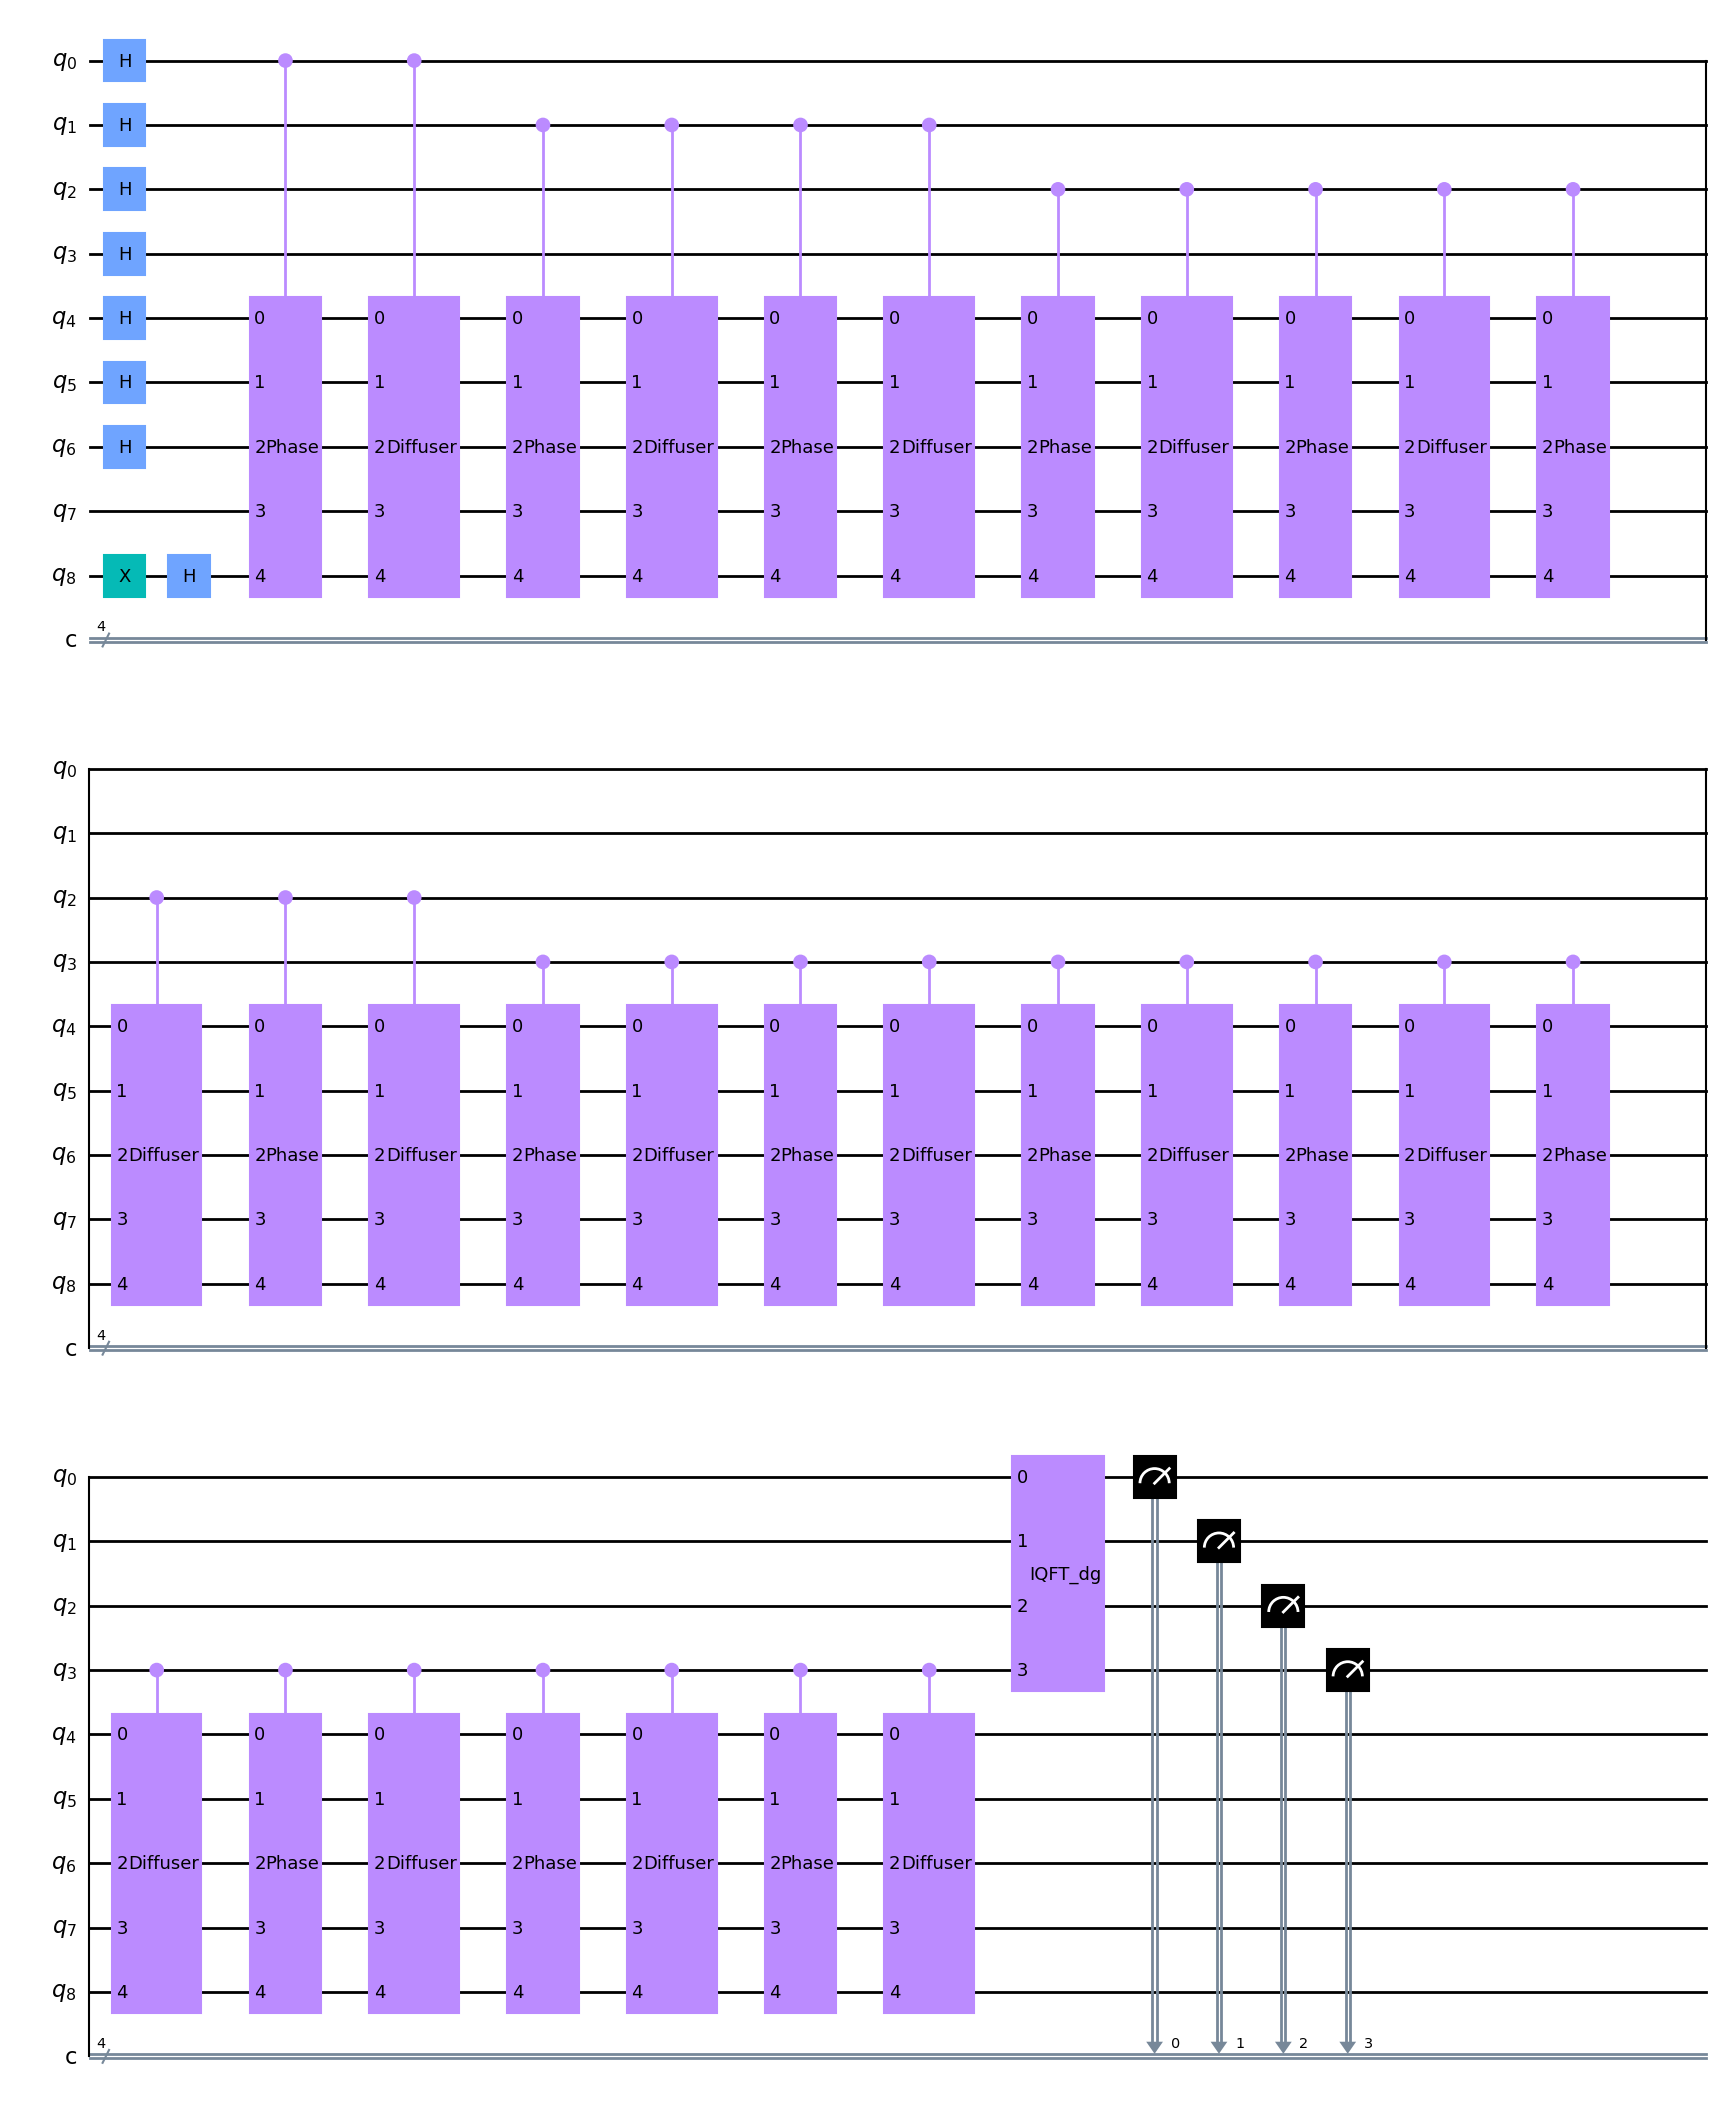

In [21]:
# Now, we create the circuit for entire Quantum Computing algorithm

n = 3 # no. of working qubits for Grover part
q = 2 * n - 1 # no. of total qubits needed for Grover part (including auxiliary and ancilla)
c = 4 # no. of measurement qubits for QPE part
QC = QuantumCircuit(c+q, c) # Circuit for Quantum Computing algorithm

QC.h(range(c+n)) # Hadamard gates on all QPE qubits and working Grover qubits

# Put ancilla qubit (last qubit) in state |->
QC.x(c+q-1)
QC.h(c+q-1)

# Implement c_U and c_V with exponent increasing by a factor of 2
repetitions = 1
for qubit in range(c): # Controlled by all QPE qubits
    for i in range(repetitions):
        # Target on all Grover qubits
        QC.append(c_U,[qubit] + list(range(c, c+q))) # [qubit] denotes control qubits, and list(range(c, c+q)) denotes target qubits
        QC.append(c_V,[qubit] + list(range(c, c+q)))    
    repetitions *= 2
    
# Adding the inverse QFT:
QC = QC.compose(QFT(c, inverse=True), range(c))

# Measure QPE qubits
for i in range(c):
    QC.measure(i, i)

QC.draw()

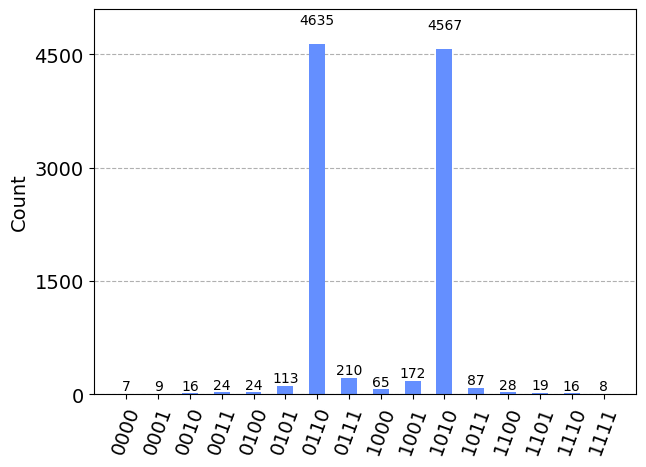

In [25]:
# Let's see the results

from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator')
job = execute(QC, backend=simulator, shots=10000)
counts = job.result().get_counts()

plot_histogram(counts)

In [30]:
# We get two histograms for two eigenvalues e^(i*theta) and e^(-i*theta) as expected

In [31]:
# Take the value of the measurement with highest probability in the histogram
import operator
highest_prob_string = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
measurement = int(highest_prob_string, 2) # Convert the output string into decimal. This is my measurement
print(f'Measurement = {measurement}')

Measurement = 6


In [67]:
# Finally calculate number of solutions by known formula

import math
N = 2**n # where n = no. of Grover working qubits
theta = 2 * math.pi * (1 - (measurement/(2**c))) # Calculate phase theta by derived formula
mu = N * (math.sin(theta/2))**2 # mu = N*(sin(theta/2))^2
num_solutions = N - mu # no. of solutions is (N-mu)
print('Number of solutions = ', num_solutions)
print('Rounded value = ', round(N - mu)) # Convert (N-mu) to the nearest integer

Number of solutions =  1.1715728752538102
Rounded value =  1


In [68]:
# Let us implement quantum counting algorithm for another Grover iterator

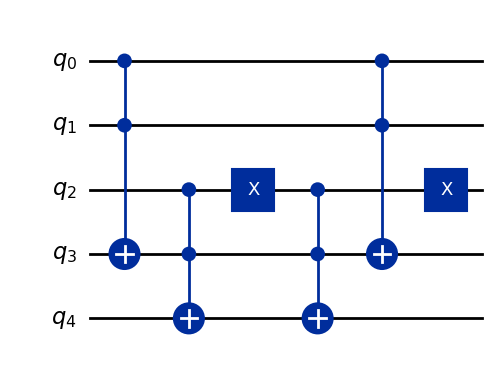

In [144]:
n = 5
qc2 = QuantumCircuit(n)
qc2.ccx(0,1,3)
qc2.ccx(2,3,4)
qc2.x(2)
qc2.ccx(2,3,4)
qc2.ccx(0,1,3)
qc2.x(2)
qc2.draw('mpl')

In [145]:
# This phase oracle marks two states, |011> and |111>. We define this to be our new phase oracle.

In [146]:
def phase_oracle_2(q,name = 'Uf'):
    qc = QuantumCircuit(q, name=name)
    qc.ccx(0,1,3)
    qc.cx(3,4)
    qc.ccx(0,1,3)
    return qc

In [147]:
# Convert phase_oracle_2 to controlled-U gate

U_gate_2 = phase_oracle_2(q).to_gate()
U_gate_2.label = "Phase"
c_U_2 = U_gate_2.control() # controlled unitary

In [148]:
# Diffuser and controlled-V remain same as previous example.

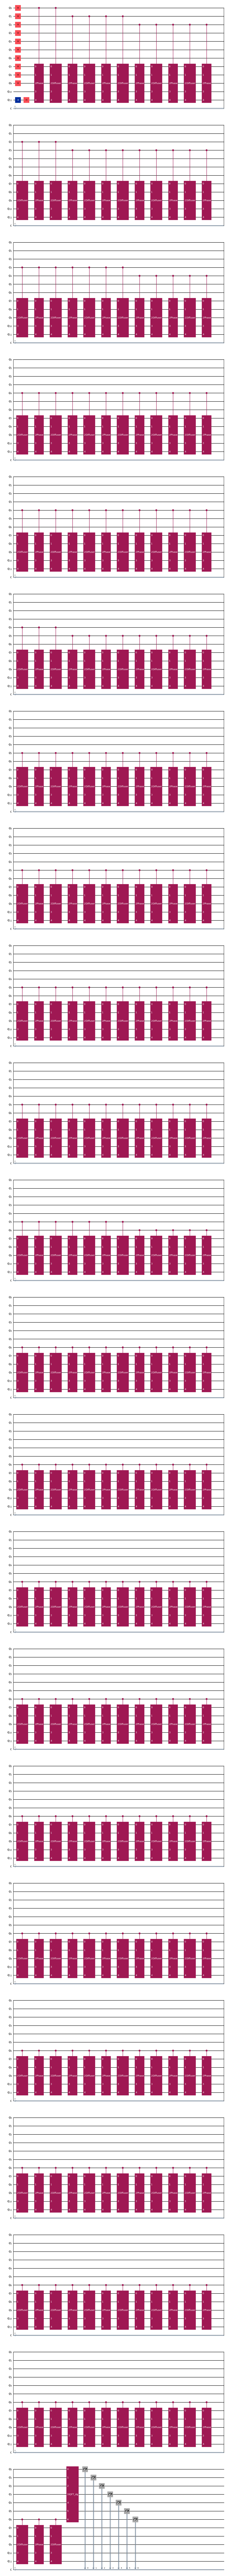

In [149]:
# Now, we create the circuit for entire Quantum Computing algorithm

n = 3 # no. of working qubits for Grover part
q = 2 * n - 1 # no. of total qubits needed for Grover part (including auxiliary and ancilla)
c = 7 # no. of measurement qubits for QPE part
QC_2 = QuantumCircuit(c+q, c) # Circuit for Quantum Computing algorithm

QC_2.h(range(c+n)) # Hadamard gates on all QPE qubits and working Grover qubits

# Put ancilla qubit (last qubit) in state |->
QC_2.x(c+q-1)
QC_2.h(c+q-1)

# Implement c_U and c_V with exponent increasing by a factor of 2
repetitions = 1
for qubit in range(c): # Controlled by all QPE qubits
    for i in range(repetitions):
        # Target on all Grover qubits
        QC_2.append(c_U_2,[qubit] + list(range(c, c+q))) # [qubit] denotes control qubits, and list(range(c, c+q)) denotes target qubits
        QC_2.append(c_V,[qubit] + list(range(c, c+q)))    
    repetitions *= 2
    
# Adding the inverse QFT:
QC_2 = QC_2.compose(QFT(c, inverse=True), range(c))

# Measure QPE qubits
for i in range(c):
    QC_2.measure(i, i)

QC_2.draw('mpl')

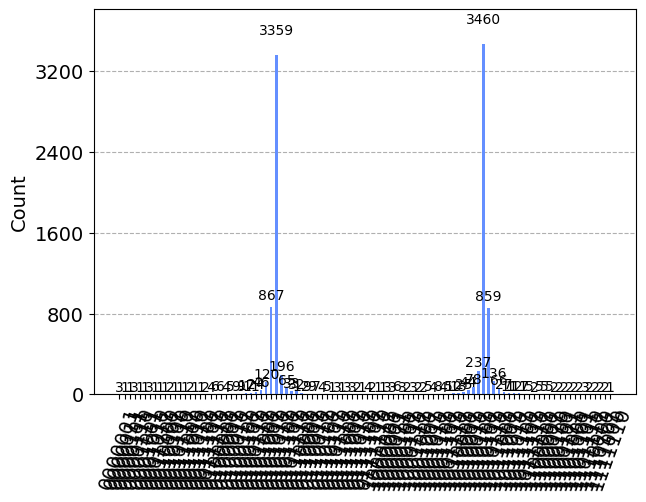

In [150]:
# Let's see the results

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

simulator = AerSimulator()
t_QC_2 = transpile(QC_2, simulator)
results = simulator.run(t_QC_2, shots=10000).result()
counts = results.get_counts()

plot_histogram(counts)

In [151]:
# We get two histograms as expected.
# Take the value of the measurement with highest probability in the histogram

import operator
highest_prob_string = max(counts.items(), key=operator.itemgetter(1))[0][::-1]
print(f'Highest probability string = {highest_prob_string}')
measurement = int(highest_prob_string, 2) # Convert the output string into decimal. This is my measurement
print(f'Measurement = {measurement}')

Highest probability string = 1010101
Measurement = 85


In [152]:
# Finally calculate number of solutions by known formula

import math
N = 2**n # where n = no. of Grover working qubits
theta = 2 * math.pi * (1 - (measurement/(2**c))) # Calculate phase theta by derived formula
mu = N * (math.sin(theta/2))**2 # mu = N*(sin(theta/2))^2
num_solutions = N - mu # no. of solutions is (N-mu)
print('Number of solutions = ', num_solutions)
print('Rounded value = ', round(N - mu)) # Convert (N-mu) to the nearest integer

Number of solutions =  1.9435890232271138
Rounded value =  2
